In [1]:
library(Seurat)
library(Signac)
library(ggplot2)

Attaching SeuratObject

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'Signac'


The following object is masked from 'package:Seurat':

    FoldChange




In [2]:
#Generating File Paths

gen.atac.path <- function(pid, data.path, summary){
    
    summ = read.csv(paste(data.path, summary, sep=""))
    
    p.summ = summ[summ$Patient == pid,]
    
    atac.date <- p.summ$date_ATAC
    atac.id <- p.summ$sampleid_ATAC
    atac.tissue <- p.summ$Tissue
    
    atac.path <- paste(data.path,
                       "scATAC-seq_",
                       atac.tissue, ".",
                       atac.date,
                       "/",
                       atac.id,
                       "/outs/",
                       sep="")
    return(atac.path)
    
}

base.path <- "/home/cyogodzi/projects/franco/"



summ <- "Single-cell_sequencing.summary.09.14.20.csv"
patient <- "43E7BL"

data.path <- paste(base.path, "francoData/", sep="")
atac.path <- gen.atac.path(patient, data.path, summ)

atac.frags <- paste(atac.path, "fragments.tsv.gz", sep="")
atac.meta <- paste(atac.path, "singlecell.csv", sep="") 
atac.peaks <- paste(atac.path, "filtered_peak_bc_matrix.h5", sep="")


rna.path <- paste(base.path,"/scRNAlabeled/", sep="")
rds.file <- list.files(rna.path)[grepl(patient, list.files(rna.path))]
rna.rds <- paste(rna.path, rds.file, sep="")


## Label-Transfer via Signac

In [91]:
#Loading Labeled scRNA data and atac peak data
rna <- readRDS(rna.rds)
peaks <- Read10X_h5(atac.peaks)

annotations <- readRDS("hg38.rds")

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"


In [70]:
#initiating atac seurat object
atac.assay <- CreateChromatinAssay(
  counts = peaks,
  sep = c(":", "-"),
  fragments = atac.frags,
  annotation = annotations,
  min.cells = 1
)

metadata <- read.csv(
  file = atac.meta,
  header = TRUE,
  row.names = 1,
  
)

atac <- CreateSeuratObject(
  counts = atac.assay,
  assay = 'peaks',
  project = 'ATAC',
  meta.data = metadata,
  annotation = annotations
)



Computing hash

Warning message in CreateSeuratObject.Assay(counts = atac.assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


In [71]:
atac <- TSSEnrichment(atac)
atac <- NucleosomeSignal(atac)


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



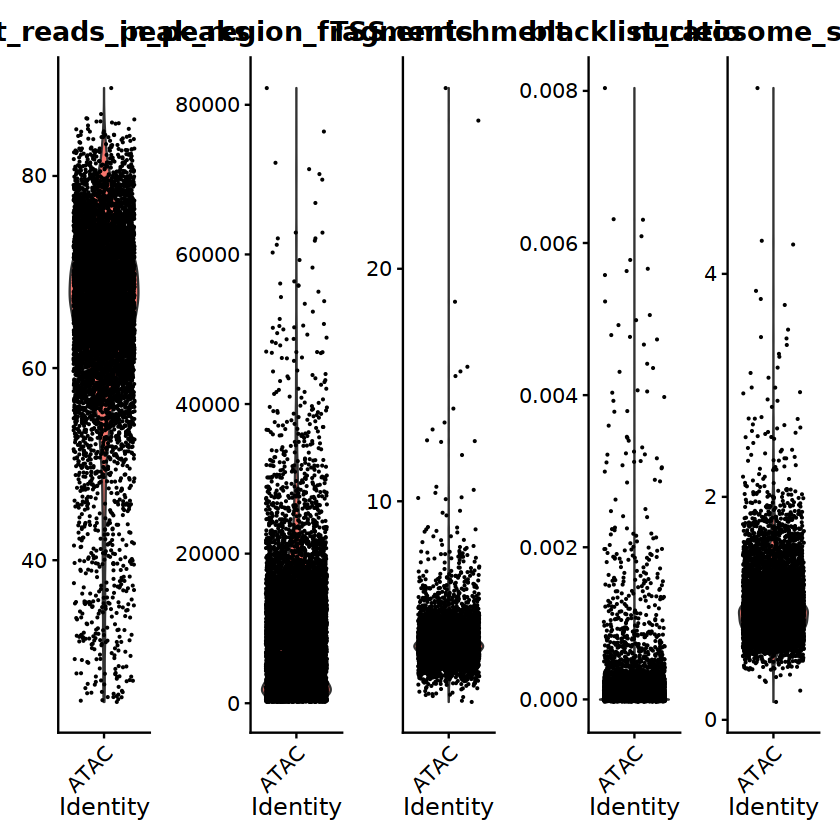

In [72]:
atac$pct_reads_in_peaks <- atac$peak_region_fragments / atac$passed_filters * 100
atac$blacklist_ratio <- atac$blacklist_region_fragments / atac$peak_region_fragments


VlnPlot(
  object = atac,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [73]:
atac <- subset(
  x = atac,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 100000 &
    pct_reads_in_peaks > 40 &
    blacklist_ratio < 0.025 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
atac

An object of class Seurat 
192750 features across 6868 samples within 1 assay 
Active assay: peaks (192750 features, 0 variable features)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



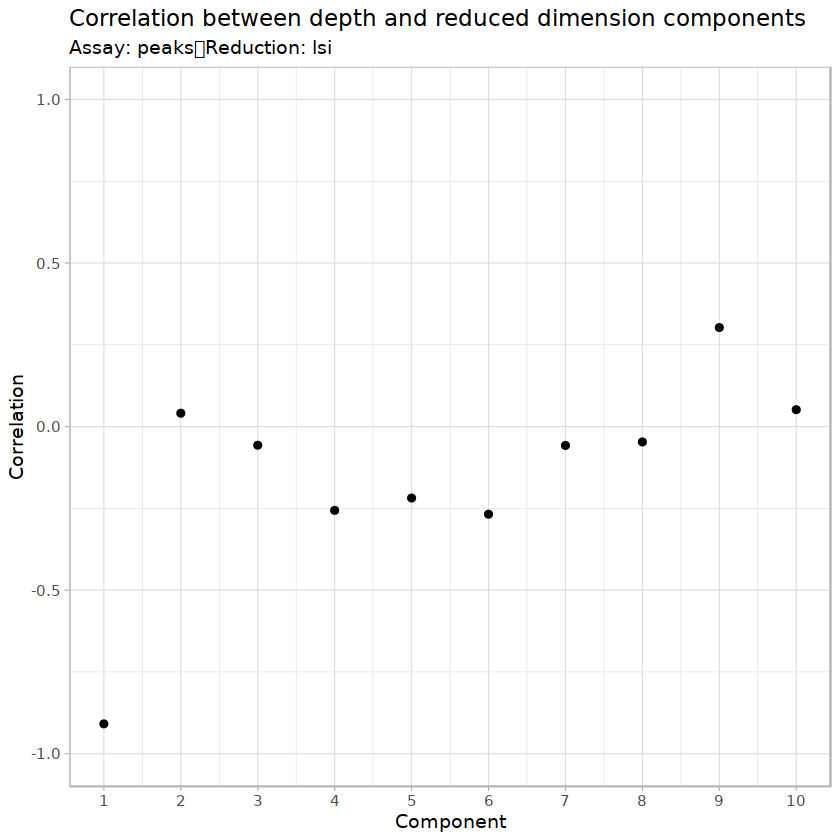

In [74]:
# We exclude the first dimension as this is typically correlated with sequencing depth
atac <- RunTFIDF(atac)
atac <- FindTopFeatures(atac, min.cutoff = "q0")
atac <- RunSVD(atac)
DepthCor(atac)

In [75]:
atac <- RunUMAP(atac, reduction = "lsi", dims=2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

21:05:30 UMAP embedding parameters a = 0.9922 b = 1.112

21:05:30 Read 6868 rows and found 29 numeric columns

21:05:30 Using Annoy for neighbor search, n_neighbors = 30

21:05:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:05:31 Writing NN index file to temp file /datastore/scratch/users/cyogodzi/Rtmpg0ARWp/file23fe46c930a9

21:05:31 Searching Annoy index using 1 thread, search_k = 3000

21:05:34 Annoy recall = 100%

21:05:38 Commencing smooth kNN distance calibration using 1 thread

21:05:44 Initializing from normalized Laplacian + noise

21:05:44 Commencing optimization for 500 epochs, with 273228 positive edges

21:06:25 Optimization finished



In [95]:
# quantify gene activity
gene.activities <- GeneActivity(atac, features = VariableFeatures(rna))

# add gene activities as a new assay
atac[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(atac) <- "ACTIVITY"
atac <- NormalizeData(atac)
atac <- ScaleData(atac, features = rownames(atac))

# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = rna,
                                        query = atac,
                                        features = VariableFeatures(object = rna), 
                                        reference.assay = "RNA",
                                        query.assay = "ACTIVITY",
                                        reduction = "cca")

Extracting gene coordinates

Extracting reads overlapping genomic regions

Centering and scaling data matrix

Warning message:
"171 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 1829 features."
Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15125 anchors

Filtering anchors

	Retained 4801 anchors



In [81]:
p1 <- DimPlot(rna, group.by = "celltypeLabels", label = TRUE)  + ggtitle("RNA") + NoLegend()
p2 <- DimPlot(atac, group.by = "orig.ident", label = FALSE)  + ggtitle("ATAC") + NoLegend()
#png("figures/43E7BL_rna_labeled.png")
p1
#dev.off()
#png("figures/43E7BL_atac_unlabeled.png")
p2
#dev.off()

png 
  2

png 
  2

In [104]:
celltype.predictions <- TransferData(anchorset = transfer.anchors,
                                     refdata = rna$celltypeLabels, 
                                     weight.reduction = atac[["lsi"]], dims = 2:30)

atac <- AddMetaData(atac, metadata = celltype.predictions)
Idents(atac) <- "predicted.id"

Finding integration vectors

Finding integration vector weights

Predicting cell labels



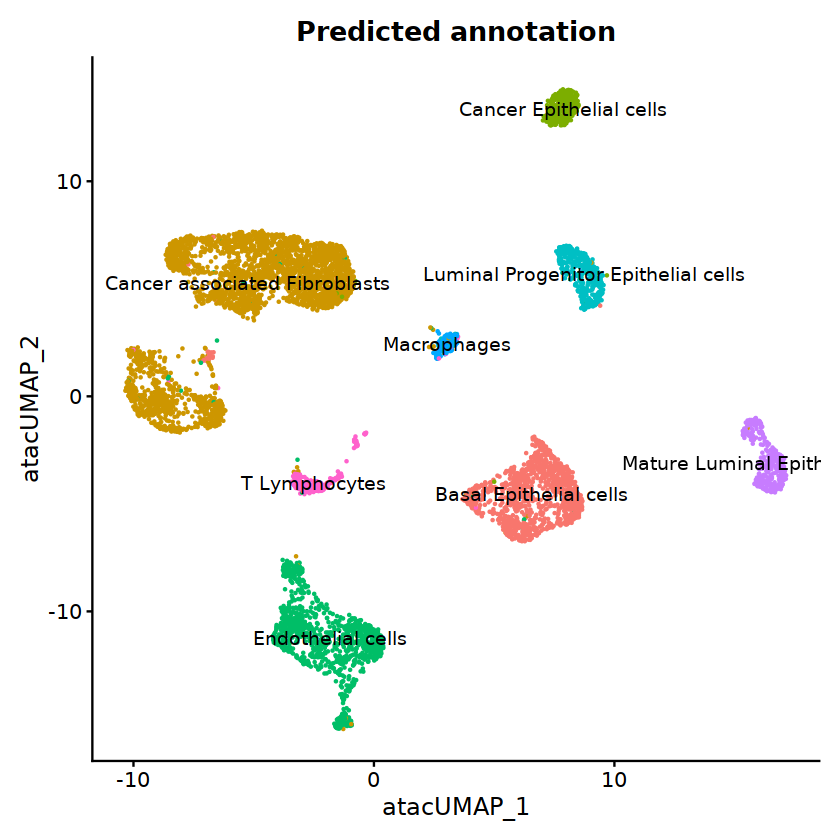

In [120]:

p3 <- DimPlot(atac, group.by = "predicted.id", label = TRUE) + ggtitle("Predicted annotation") + NoLegend()
#png("figures/43E7BL_atac_legend.png")
p3
#dev.off()

In [119]:
#find Differentially Accesible regions by cell cluster
DefaultAssay(atac) <- "peaks"

cell.labels <- names(table(atac$predicted.id))
non.canc <- cell.labels[cell.labels != "Cancer Epithelial cells"]

da_peaks <- FindMarkers(
  object = atac,
  ident.1 = c("Cancer Epithelial cells"), 
  ident.2 = non.canc,
  min.pct = 0.4,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10-73601104-73602303,0,3.352186,0.900,0.052,0
chr10-73624701-73627229,0,2.248063,0.919,0.266,0
chr10-73743317-73745532,0,2.197563,0.929,0.313,0
chr10-73771005-73775061,0,2.443628,0.987,0.353,0
chr10-73784747-73787444,0,2.242577,0.965,0.333,0
chr10-73808163-73813736,0,2.288237,0.974,0.385,0


In [138]:
granges(atac[rownames(da_peaks[da_peaks$p_val_adj < 0.05,]),])

GRanges object with 645 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]     chr1      997028-1002422      *
    [2]     chr1     1304020-1311650      *
    [3]     chr1     2226470-2233214      *
    [4]     chr1     2310381-2323830      *
    [5]     chr1     3899376-3901915      *
    ...      ...                 ...    ...
  [641]    chr21   26842091-26847348      *
  [642]    chr21   45363577-45367846      *
  [643]    chr21   45970358-45975674      *
  [644]    chr22   24242160-24248336      *
  [645]     chrX 107672743-107677952      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

NULL